In [36]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import numpy as np
import statsmodels.api as sm

In [10]:
df = pd.read_csv('/Users/jingwen.wang/Desktop/Python/Japan_SD_Data.csv', parse_dates=['Month'], index_col="Month")
df = df[["Kerosene"]]
df.head()

,Kerosene
Month,
2002-01-01,4585397
2002-02-01,3973421
2002-03-01,3022325
2002-04-01,1701263
2002-05-01,1136584


In [4]:
df.iloc[:,0]=pd.to_numeric(df.iloc[:,0], errors="coerce") 
# errors = "coerce" --- invalid parsing will be set as NaN

In [6]:
df = df.interpolate()

In [11]:
# Test for stationary
dicky = adfuller(df)
print(dicky[1])
# since >0.05, need to use trend and seasonality

0.3133761188542296


In [16]:
# Last 10% of the data for testing
# 90% for train
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

211 24


In [18]:
# MOVING AVERAGE
pred = test.copy()
pred['MA'] = train.iloc[:,0].rolling(60).mean().iloc[-1]
mean_squared_error(pred['MA'],test["Kerosene"])**0.5

757469.4778202056

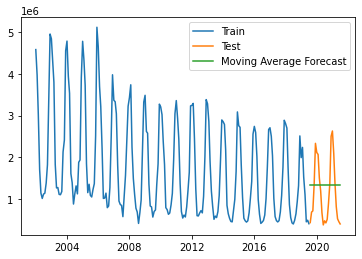

In [20]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred['MA'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [24]:
# EXPONENTIAL SMOOTHING
pred = test.copy()
model = SimpleExpSmoothing(np.asarray(train.iloc[:,0])).fit(smoothing_level=0.6) 
#0.6 is for y(t) and 0.4 is for y(t-1 and below)
pred['ES'] = model.forecast(len(test))
mean_squared_error(pred['ES'],test["Kerosene"])**0.5

1000086.4138733406

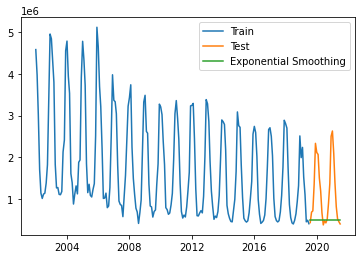

In [26]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred['ES'], label='Exponential Smoothing')
plt.legend(loc='best')
plt.show()

In [31]:
# HOLT
# Exponential smoothing with trend
pred = test.copy()

#0.3 is for y(t) and 0.7 is for y(t-1 and below, slope/gradient =0.1)
model = Holt(np.asarray(train.iloc[:,0])).fit(smoothing_level = 0.3,smoothing_trend = 0.1) 
# use smoothing_slope instead of smoothing_trend
pred['Holt'] = model.forecast(len(test))
mean_squared_error(pred['Holt'],test["Kerosene"])**0.5

C:\Users\jingwen.wang\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


1262458.7871161755

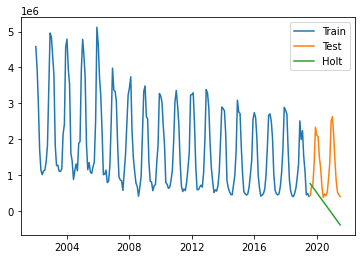

In [32]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred['Holt'], label='Holt')
plt.legend(loc='best')
plt.show()

In [34]:
# HOLT WINTER
# Exponential moothing with trend + seasonal 
pred = test.copy()
model = ExponentialSmoothing(train, trend='add').fit()
pred['Holt_Winter'] = model.forecast(len(test))
mean_squared_error(pred['Holt_Winter'],test["Kerosene"])**0.5

C:\Users\jingwen.wang\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jingwen.wang\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\jingwen.wang\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2168619.5163047127

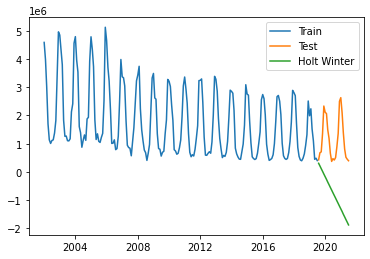

In [35]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred['Holt_Winter'], label='Holt Winter')
plt.legend(loc='best')
plt.show()

In [38]:
# SARIMA
# ARIMA + Seasonality
# Order (4, 1, 4) - usually small
pred = test.copy()
model = sm.tsa.statespace.SARIMAX(train.iloc[:,0], order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()

pred['SARIMA'] = model.forecast(len(test))
mean_squared_error(pred['SARIMA'],test["Kerosene"])**0.5


C:\Users\jingwen.wang\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jingwen.wang\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


712393.3407972176

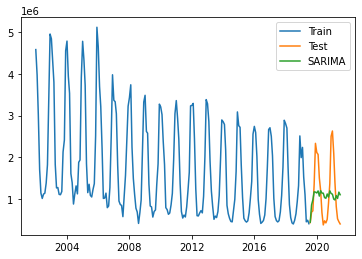

In [39]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

<ipython-input-40-a816841734c7>:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(train, model='additive', freq=2)


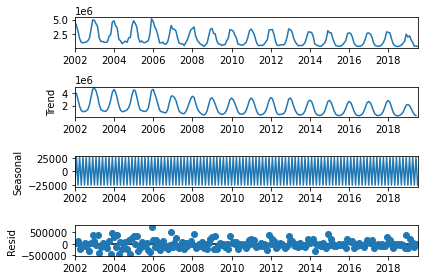

In [40]:
# DECOMPOSE
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(train, model='additive', freq=2)
trend = decomposition.trend.dropna()
seasonal=decomposition.seasonal.dropna()
residual=decomposition.resid.dropna()

decomposition.plot()
plt.show()

In [41]:
# check dicky fuller on the residual

print(residual)
result = adfuller(residual)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # p-value > 0.05 means there non-stationary, need to use non stationary model

Month
2002-02-01     59121.316312
2002-03-01    118150.183688
2002-04-01   -214754.433688
2002-05-01    -83620.566312
2002-06-01    -83439.683688
                  ...      
2019-02-01    213715.316312
2019-03-01    -46068.566312
2019-04-01     30994.066312
2019-05-01   -146728.566312
2019-06-01      4866.816312
Name: resid, Length: 209, dtype: float64
ADF Statistic: -9.764795
p-value: 0.000000


In [45]:
#Without Customization (On Test Set) Additive
pred =  trend + seasonal + residual

pred = pred.dropna()[-len(test):]

print(pred)
print(test)
mean_squared_error(pred, test["Kerosene"])**0.5

Month
2017-07-01     444491.0
2017-08-01     475293.0
2017-09-01     687126.0
2017-10-01    1078374.0
2017-11-01    1760495.0
2017-12-01    2887701.0
2018-01-01    2807021.0
2018-02-01    2699335.0
2018-03-01    1736330.0
2018-04-01     863532.0
2018-05-01     549709.0
2018-06-01     421373.0
2018-07-01     395209.0
2018-08-01     483211.0
2018-09-01     639606.0
2018-10-01     932756.0
2018-11-01    1318145.0
2018-12-01    2511390.0
2019-01-01    1989703.0
2019-02-01    2235514.0
2019-03-01    1523829.0
2019-04-01    1099053.0
2019-05-01     447666.0
2019-06-01     485828.0
dtype: float64
            Kerosene
Month               
2019-08-01    428942
2019-09-01    680268
2019-10-01    710459
2019-11-01   1354699
2019-12-01   2333095
2020-01-01   2112623
2020-02-01   2066032
2020-03-01   1501425
2020-04-01   1188381
2020-05-01    665823
2020-06-01    373083
2020-07-01    471104
2020-08-01    421859
2020-09-01    507812
2020-10-01    885118
2020-11-01   1364090
2020-12-01   2500589
2021

525706.2419083257

In [48]:
#Without Customization (On Test Set) Additive
pred =  1.1*trend + 1.1*seasonal + 1.1*residual

pred = pred.dropna()[-len(test):]

print(pred)
print(test)
mean_squared_error(pred, test["Kerosene"])**0.5

Month
2017-07-01     488940.1
2017-08-01     522822.3
2017-09-01     755838.6
2017-10-01    1186211.4
2017-11-01    1936544.5
2017-12-01    3176471.1
2018-01-01    3087723.1
2018-02-01    2969268.5
2018-03-01    1909963.0
2018-04-01     949885.2
2018-05-01     604679.9
2018-06-01     463510.3
2018-07-01     434729.9
2018-08-01     531532.1
2018-09-01     703566.6
2018-10-01    1026031.6
2018-11-01    1449959.5
2018-12-01    2762529.0
2019-01-01    2188673.3
2019-02-01    2459065.4
2019-03-01    1676211.9
2019-04-01    1208958.3
2019-05-01     492432.6
2019-06-01     534410.8
dtype: float64
            Kerosene
Month               
2019-08-01    428942
2019-09-01    680268
2019-10-01    710459
2019-11-01   1354699
2019-12-01   2333095
2020-01-01   2112623
2020-02-01   2066032
2020-03-01   1501425
2020-04-01   1188381
2020-05-01    665823
2020-06-01    373083
2020-07-01    471104
2020-08-01    421859
2020-09-01    507812
2020-10-01    885118
2020-11-01   1364090
2020-12-01   2500589
2021

607492.8923602256

In [50]:
# Using Multiplicative
decomposition = seasonal_decompose(train, model='multiplicative', freq=2)
trend = decomposition.trend.dropna()
seasonal=decomposition.seasonal.dropna()
residual=decomposition.resid.dropna()

#Without Customization (On Test Set) Additive
pred =  1.1*trend*seasonal*residual

pred = pred.dropna()[-len(test):]

mean_squared_error(pred, test["Kerosene"])**0.5

<ipython-input-50-337ae0820ef7>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(train, model='multiplicative', freq=2)


607492.8923602256